# Track definition from aerial photography
Generate a parameterized track definition from a masked image based on aerial photography.

The goal of this notebook is to determine the track centreline & curvature, track width and length from a pre-masked image, likely based on aerial photography.

# Approach
## Point array of inner and outer contours
Given an image mask of a race track, identify the inner and outer contours of the racing circuit assuming the track is closed.

Let:
* $x_{in}^i, y_{in}^i, i = 1, 2, ..., n$ represent the inner contour of the track
* $x_{out}^j, y_{out}^j, j = 1, 2, ..., m$ represent the outer contour of the track

Where $x_{in}, y_{in}$ and $x_{out}, y_{out}$ are identified using image processing techniques

## Perpendicular line from inner contour
Given a point $x_{in}^i, y_{in}^i$, identify a perpendicular line to that point.

## Nearest Neighbours

## Identify intercept

## Calculate Track Width, Centreline

In [3]:
%matplotlib notebook

import cv2
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

## Read the initial image and find inner/outer track limits
Open a pre-masked image and process it with OpenCV. The track surface is represented by the pixels in black, and non-track surfaces are represented by the pixles in white.

The goal using OpenCV is to:
* Read in the image
* Identify the inner and outer contours of the race track
* Filter and decimate the data points representing the contours

In [4]:
img = cv2.imread('TMP.png', 0)
img

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

<IPython.core.display.Javascript object>


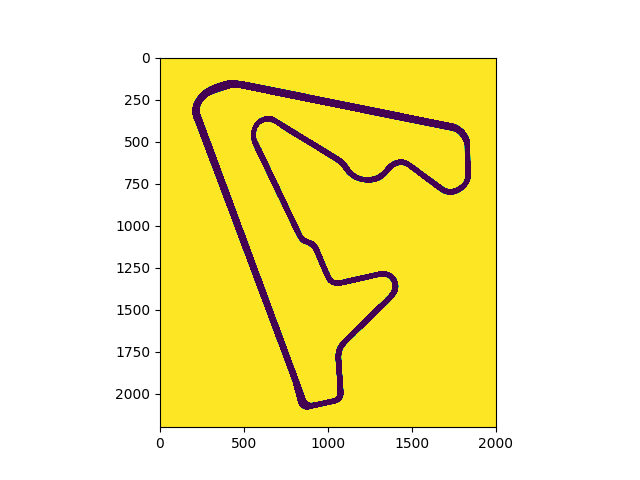

In [5]:
plt.figure()
plt.imshow(img)
plt.show()

In [6]:
# Find contours
contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

<IPython.core.display.Javascript object>


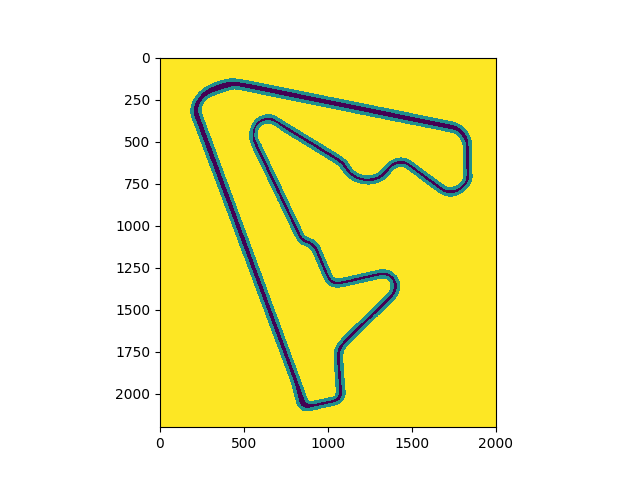

In [7]:
draw = np.copy(img)
cv2.drawContours(draw, contours, 1, 127, 20)
cv2.drawContours(draw, contours, 2, 127, 20)

plt.figure()
plt.imshow(draw)
plt.show()

In [8]:
def decimate_and_filter(signal, factor, ftype, n):
    return scipy.signal.decimate(signal.astype(np.float32), factor, ftype=ftype, n=n)[0]


def decimate_and_filter_contour(contour, factor, ftype, n):
    x, y = contour.T
    return {"x": decimate_and_filter(x, 10, 'iir', 3),
            "y": decimate_and_filter(y, 10, 'iir', 3)}


inner_contour = decimate_and_filter_contour(contours[2], 10, 'iir', 3)
outer_contour = decimate_and_filter_contour(contours[1], 10, 'iir', 3)

<IPython.core.display.Javascript object>


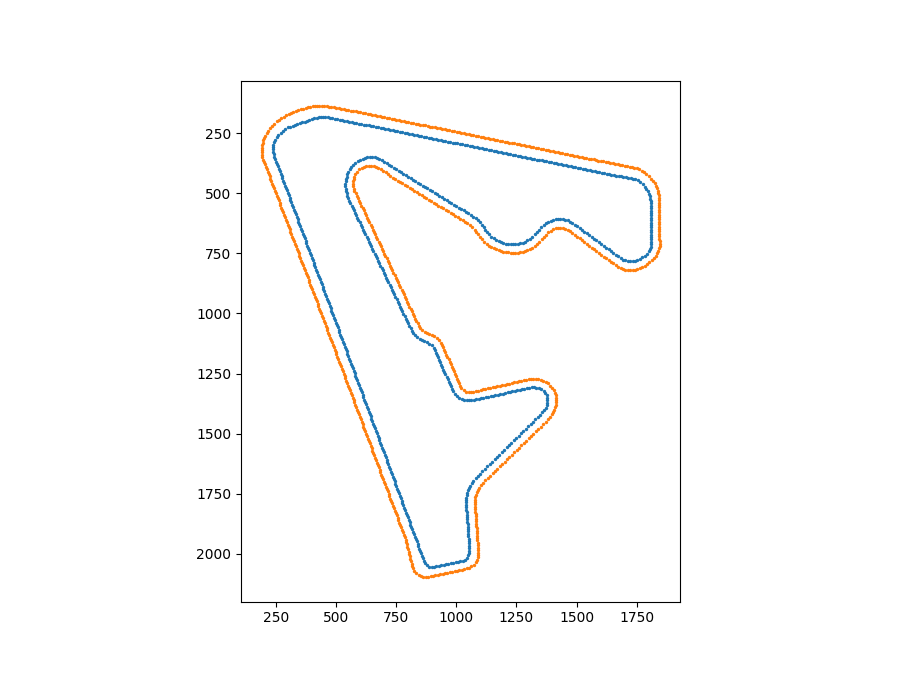

In [9]:
plt.figure()

plt.scatter(inner_contour['x'], inner_contour['y'], s=2)
plt.scatter(outer_contour['x'], outer_contour['y'], s=2)

plt.axis('scaled')
plt.gca().invert_yaxis()

plt.show()

## Find the gradient of the inner contour


In [10]:
def gradient_closed_array(array):
    # Calculates the gradient of an array using central differences
    # Corrects the gradient at the tails assuming array is circular
    gradient = np.gradient(array)
    gradient[0] = 0.5 * (array[-1] - array[1])
    gradient[-1] = 0.5 * (array[-2] - array[0])
    return gradient

inner_contour['dx'] = gradient_closed_array(inner_contour['x'])
inner_contour['dy'] = gradient_closed_array(inner_contour['y'])
outer_contour['dx'] = gradient_closed_array(outer_contour['x'])
outer_contour['dy'] = gradient_closed_array(outer_contour['y'])

# Calculate the slope
inner_contour['m'] = inner_contour['dy'] / inner_contour['dx']
inner_contour['mp'] = 1 / inner_contour['m']

In [44]:
# Nearest neighbour from the perpendicular line to the outer contour
# Define a vector from the inner contour point to all the points

x, y = inner_contour['x'][1], inner_contour['y'][1]
unit_vector = np.array([inner_contour['dx'][1], inner_contour['dy'][1]])
unit_vector /= np.linalg.norm(unit_vector)

direction_vector = np.column_stack((outer_contour['x'] - x,
                                    outer_contour['y'] - y))

dist = [np.dot(v, bhat) for v in a]

In [45]:
unit_vector

array([-0.98249153,  0.18630726])

<IPython.core.display.Javascript object>


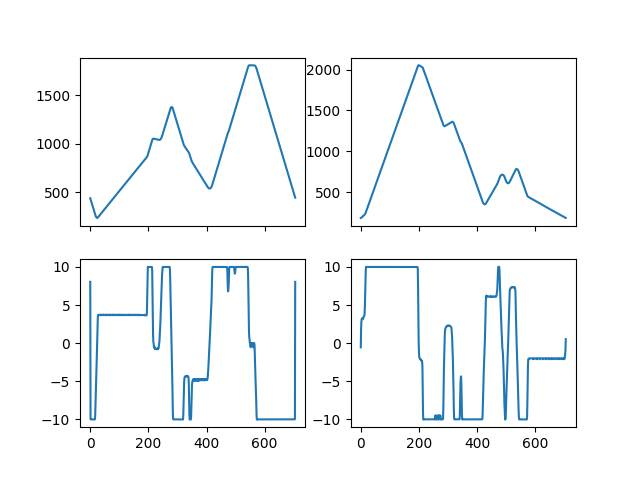

<IPython.core.display.Javascript object>


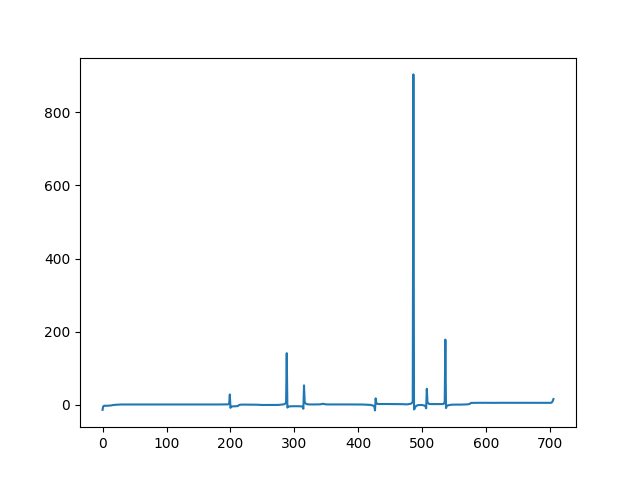

In [25]:
fig, ax = plt.subplots(2,2,sharex=True)

n = np.arange(0, len(inner_contour['x']))

ax[0,0].plot(n, inner_contour['x'])
ax[1,0].plot(n, inner_contour['dx'])

ax[0,1].plot(n, inner_contour['y'])
ax[1,1].plot(n, inner_contour['dy'])

plt.show()

plt.figure()
plt.plot(n, inner_contour['mp'])